## COVID Vaccination Regression Analysis
#### Anthony Buttitta

In [52]:
#general libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import randint

#scikit learn imports
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [53]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file,sourcePath,compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [54]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#code to prevent warnings that can occur as a result of this function
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

In [55]:
path = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt4/"

#compressedfile = "housing.tgz"
filename = 'COVID_31Dec2021.csv'

#download data files if not currently downloaded into the current working directory
downloadDataResource(filename, path)

#create the dataframe
covid = pd.read_csv(filename)

Data resource COVID_31Dec2021.csv already downloaded.


In [56]:
filename2 = "ElectionEconomicSocialDataByFIPS.csv"

#download data files if not currently downloaded into the current working directory
downloadDataResource(filename2, path)

#create the dataframe
fips = pd.read_csv(filename2)

Data resource ElectionEconomicSocialDataByFIPS.csv already downloaded.


In [57]:
data = pd.merge(covid, fips, left_on='fips', right_on='fips', how='inner')

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3140 entries, 0 to 3139
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fips              3140 non-null   int64  
 1   state             3140 non-null   object 
 2   county            3140 non-null   object 
 3   population        3140 non-null   int64  
 4   vaccinationRate   3007 non-null   float64
 5   cases             3140 non-null   int64  
 6   deaths            3140 non-null   int64  
 7   Region            3140 non-null   object 
 8   MedianIncome      3140 non-null   int64  
 9   PovertyEst        3140 non-null   int64  
 10  LaborForce        3140 non-null   int64  
 11  UnemploymentRate  3140 non-null   float64
 12  Older             3004 non-null   float64
 13  Urban             3004 non-null   float64
 14  Trump2016         3004 non-null   float64
 15  Trump2020         3004 non-null   float64
 16  RepGov            3004 non-null   float64


In [59]:
data.dropna( subset=['vaccinationRate'], inplace=True )

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3007 entries, 0 to 3139
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fips              3007 non-null   int64  
 1   state             3007 non-null   object 
 2   county            3007 non-null   object 
 3   population        3007 non-null   int64  
 4   vaccinationRate   3007 non-null   float64
 5   cases             3007 non-null   int64  
 6   deaths            3007 non-null   int64  
 7   Region            3007 non-null   object 
 8   MedianIncome      3007 non-null   int64  
 9   PovertyEst        3007 non-null   int64  
 10  LaborForce        3007 non-null   int64  
 11  UnemploymentRate  3007 non-null   float64
 12  Older             2873 non-null   float64
 13  Urban             2873 non-null   float64
 14  Trump2016         2873 non-null   float64
 15  Trump2020         2873 non-null   float64
 16  RepGov            2873 non-null   float64


In [61]:
data.describe()

,fips,population,vaccinationRate,cases,deaths,MedianIncome,PovertyEst,LaborForce,UnemploymentRate,Older,Urban,Trump2016,Trump2020,RepGov,Female,AdherentPercent
count,3007.000000,3.007000e+03,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3.007000e+03,3007.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2979.000000
mean,30999.837712,9.387461e+04,0.483812,15781.871633,242.287662,57009.589957,11070.285002,4.602749e+04,6.708547,17.143862,40.924800,64.300695,65.613778,0.599025,0.172990,51.804811
std,14947.496624,2.596490e+05,0.115351,44799.188745,698.015484,14199.762603,33416.318042,1.309762e+05,2.249145,4.277575,31.205376,15.246334,15.690204,0.490181,0.378304,17.980302
min,1001.000000,1.690000e+02,0.030000,0.000000,0.000000,22901.000000,7.000000,1.840000e+02,1.700000,4.691211,0.000000,8.342566,8.730038,0.000000,0.000000,3.064889
25%,19136.000000,1.088200e+04,0.405000,1884.000000,34.000000,47552.000000,1445.500000,4.826500e+03,5.200000,14.498830,11.810000,55.908450,56.697390,0.000000,0.000000,39.051889
50%,30027.000000,2.547400e+04,0.474000,4497.000000,80.000000,54857.000000,3439.000000,1.130400e+04,6.500000,16.782250,39.930000,67.355440,68.866920,1.000000,0.000000,50.243000
75%,46030.000000,6.660750e+04,0.551000,11491.000000,189.000000,63647.500000,8217.000000,3.017950e+04,8.000000,19.268550,65.570000,75.467840,77.595630,1.000000,0.000000,62.599944
max,56045.000000,5.150233e+06,1.304000,870352.000000,13675.000000,160305.000000,747146.000000,2.539907e+06,21.500000,55.481680,100.000000,95.272730,96.181820,1.000000,1.000000,192.460889


<AxesSubplot:>

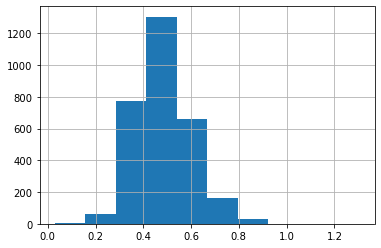

In [62]:
data.vaccinationRate.hist()

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3007 entries, 0 to 3139
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fips              3007 non-null   int64  
 1   state             3007 non-null   object 
 2   county            3007 non-null   object 
 3   population        3007 non-null   int64  
 4   vaccinationRate   3007 non-null   float64
 5   cases             3007 non-null   int64  
 6   deaths            3007 non-null   int64  
 7   Region            3007 non-null   object 
 8   MedianIncome      3007 non-null   int64  
 9   PovertyEst        3007 non-null   int64  
 10  LaborForce        3007 non-null   int64  
 11  UnemploymentRate  3007 non-null   float64
 12  Older             2873 non-null   float64
 13  Urban             2873 non-null   float64
 14  Trump2016         2873 non-null   float64
 15  Trump2020         2873 non-null   float64
 16  RepGov            2873 non-null   float64


In [64]:
data.describe()

,fips,population,vaccinationRate,cases,deaths,MedianIncome,PovertyEst,LaborForce,UnemploymentRate,Older,Urban,Trump2016,Trump2020,RepGov,Female,AdherentPercent
count,3007.000000,3.007000e+03,3007.000000,3007.000000,3007.000000,3007.000000,3007.000000,3.007000e+03,3007.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2873.000000,2979.000000
mean,30999.837712,9.387461e+04,0.483812,15781.871633,242.287662,57009.589957,11070.285002,4.602749e+04,6.708547,17.143862,40.924800,64.300695,65.613778,0.599025,0.172990,51.804811
std,14947.496624,2.596490e+05,0.115351,44799.188745,698.015484,14199.762603,33416.318042,1.309762e+05,2.249145,4.277575,31.205376,15.246334,15.690204,0.490181,0.378304,17.980302
min,1001.000000,1.690000e+02,0.030000,0.000000,0.000000,22901.000000,7.000000,1.840000e+02,1.700000,4.691211,0.000000,8.342566,8.730038,0.000000,0.000000,3.064889
25%,19136.000000,1.088200e+04,0.405000,1884.000000,34.000000,47552.000000,1445.500000,4.826500e+03,5.200000,14.498830,11.810000,55.908450,56.697390,0.000000,0.000000,39.051889
50%,30027.000000,2.547400e+04,0.474000,4497.000000,80.000000,54857.000000,3439.000000,1.130400e+04,6.500000,16.782250,39.930000,67.355440,68.866920,1.000000,0.000000,50.243000
75%,46030.000000,6.660750e+04,0.551000,11491.000000,189.000000,63647.500000,8217.000000,3.017950e+04,8.000000,19.268550,65.570000,75.467840,77.595630,1.000000,0.000000,62.599944
max,56045.000000,5.150233e+06,1.304000,870352.000000,13675.000000,160305.000000,747146.000000,2.539907e+06,21.500000,55.481680,100.000000,95.272730,96.181820,1.000000,1.000000,192.460889


In [65]:
data.corr()

,fips,population,vaccinationRate,cases,deaths,MedianIncome,PovertyEst,LaborForce,UnemploymentRate,Older,Urban,Trump2016,Trump2020,RepGov,Female,AdherentPercent
fips,1.000000,-0.007849,0.056759,-0.021254,-0.029380,0.076530,-0.012729,-0.005963,0.063757,0.032904,0.018379,0.024215,0.036793,-0.098324,-0.208806,0.040285
population,-0.007849,1.000000,0.306240,0.969726,0.941232,0.290824,0.953256,0.997465,0.182668,-0.249972,0.446356,-0.374972,-0.390326,-0.043686,-0.058617,-0.052203
vaccinationRate,0.056759,0.306240,1.000000,0.279379,0.249064,0.425795,0.240990,0.312665,0.232792,-0.090385,0.413451,-0.654104,-0.672125,-0.315744,0.070089,-0.073861
cases,-0.021254,0.969726,0.279379,1.000000,0.954770,0.253761,0.934283,0.963499,0.178942,-0.240088,0.429491,-0.341956,-0.352300,-0.028869,-0.059775,-0.038529
deaths,-0.029380,0.941232,0.249064,0.954770,1.000000,0.196630,0.939198,0.925228,0.217032,-0.196910,0.404757,-0.326846,-0.334261,-0.024062,-0.057963,-0.033065
MedianIncome,0.076530,0.290824,0.425795,0.253761,0.196630,1.000000,0.149157,0.309645,-0.158805,-0.302898,0.390442,-0.196238,-0.244330,-0.157680,-0.016614,-0.052703
PovertyEst,-0.012729,0.953256,0.240990,0.934283,0.939198,0.149157,1.000000,0.936574,0.208980,-0.226616,0.395688,-0.354810,-0.360266,-0.020691,-0.051738,-0.043659
LaborForce,-0.005963,0.997465,0.312665,0.963499,0.925228,0.309645,0.936574,1.000000,0.169170,-0.255909,0.445184,-0.377283,-0.393905,-0.046121,-0.056823,-0.049202
UnemploymentRate,0.063757,0.182668,0.232792,0.178942,0.217032,-0.158805,0.208980,0.169170,1.000000,-0.097823,0.232056,-0.396753,-0.383996,-0.209618,-0.131664,-0.266106
Older,0.032904,-0.249972,-0.090385,-0.240088,-0.196910,-0.302898,-0.226616,-0.255909,-0.097823,1.000000,-0.484846,0.299851,0.310180,-0.089784,0.100940,0.045670


In [66]:
data["Region"].value_counts()

Southeast         1059
Plains             606
Great Lakes        437
Southwest          379
Mideast            177
Rocky Mountain     172
Far west           123
New England         54
Name: Region, dtype: int64

In [67]:
#copies Delaware County data to a new dataset for later predictions
X_instance = data[ data.fips == 42045 ]
X_instance = X_instance.drop(columns = ['vaccinationRate', 'county', 'fips'])

In [68]:
X_instance.shape

(1, 16)

In [69]:
data = data[ data.fips != 42045 ].copy() 

In [70]:
#by adding the stratify feature to the train_test_split, can ensure a more representative collection of data
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['vaccinationRate', 'county', 'fips']),
    data.vaccinationRate, 
    test_size=0.2, 
    random_state=33, 
    stratify=data.Region
)

In [71]:
#show the size of the data sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2404, 16), (2404,), (602, 16), (602,))

In [72]:
cat_attribs = ["Region","state"]

#set the numerical attributes
num_attribs = list( X_train.drop(columns=cat_attribs) )

#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled 
num_pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy="median")), 
    ('std_scaler', StandardScaler()),   
] )

#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse=False), cat_attribs)    
])

In [73]:
#take the training data set and create an array of prepared data
X_train = full_pipeline.fit_transform(X_train)

In [74]:
X_test = full_pipeline.transform(X_test)

In [75]:
X_test.shape

(602, 70)

In [76]:
X_train.shape

(2404, 70)

In [77]:
#capture a list of all the features used in the model

#gets the order of encoded categories (if any)
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = []
if hasattr(cat_encoder, 'categories_'):
    for i in cat_encoder.categories_:
        cat_one_hot_attribs += list(i)
        
#combines the numeric and encoded features
attributes = list(num_attribs) + list(cat_one_hot_attribs)

attributes

['population',
 'cases',
 'deaths',
 'MedianIncome',
 'PovertyEst',
 'LaborForce',
 'UnemploymentRate',
 'Older',
 'Urban',
 'Trump2016',
 'Trump2020',
 'RepGov',
 'Female',
 'AdherentPercent',
 'Far west',
 'Great Lakes',
 'Mideast',
 'New England',
 'Plains',
 'Rocky Mountain',
 'Southeast',
 'Southwest',
 'AK',
 'AL',
 'AR',
 'AZ',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'GA',
 'HI',
 'IA',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY']

In [78]:
#calculate the average game sales
baseline_prediction = data['vaccinationRate'].mean()

#populate an array with the baseline prediction value
predictions = np.full(shape=data.shape[0], fill_value = baseline_prediction)

#determine the Root Mean Squared Error based on the actual vs. the baseline prediction
baseline_rmse = mean_squared_error(data['vaccinationRate'], predictions, squared=False)
print("Baseline guess is: {:.5f}".format(baseline_prediction))
print("Baseline Performance (of this guess): RMSE {:.5f}".format(baseline_rmse))

Baseline guess is: 0.48378
Baseline Performance (of this guess): RMSE 0.11533


In [79]:
#create a linear regression model
lin_reg=LinearRegression()

#fit the model to the training data set
lin_reg.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = lin_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.06889


In [80]:
#run cross validation
scores = cross_val_score(lin_reg, X_train, y_train,
                         scoring="neg_root_mean_squared_error",
                         cv=10)
#report the results
print("RMSE: {:.5f}".format( np.median(-scores) ))

RMSE: 0.07812


In [81]:
#use the linear regression model and evaluate the test data set
predictions = lin_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.07625


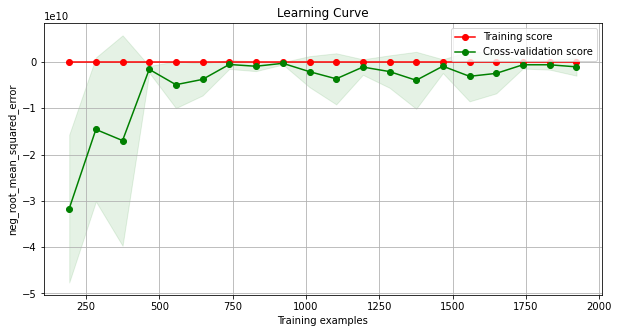

In [82]:
plot_learning_curve(lin_reg, X_train, y_train)

In [83]:
# for linear regression models, the coeffient of each attribute signifies its importance
# attributes was a variable created above; lin_reg.coef_ is a detail provided by the model

sorted(zip(lin_reg.coef_, attributes), reverse=True)

[(149056008019.8045, 'AK'),
 (149056008019.79926, 'WA'),
 (149056008019.77786, 'HI'),
 (149056008019.7456, 'NV'),
 (149056008019.48602, 'OR'),
 (69655525099.3416, 'Plains'),
 (66753986449.46422, 'Southwest'),
 (35250648939.54739, 'Southeast'),
 (27058318526.253765, 'Great Lakes'),
 (19663636593.105362, 'New England'),
 (0.13106282904793345, 'Female'),
 (0.05140921679020707, 'population'),
 (0.03453886179837043, 'RepGov'),
 (0.03252598547417459, 'MedianIncome'),
 (0.023089416627706798, 'Older'),
 (0.011948126034611706, 'Urban'),
 (0.008642427287172356, 'AdherentPercent'),
 (0.007631175926274173, 'UnemploymentRate'),
 (0.0008165326852427046, 'cases'),
 (-0.011353767838900049, 'PovertyEst'),
 (-0.011390600573520093, 'deaths'),
 (-0.023732351282082433, 'Trump2020'),
 (-0.03131629745721723, 'LaborForce'),
 (-0.034764886467813, 'Trump2016'),
 (-835947501.1375002, 'Mideast'),
 (-1775765097.3216064, 'Rocky Mountain'),
 (-6074939544.957536, 'CO'),
 (-6074939544.982665, 'MT'),
 (-6074939545.0290

In [84]:
#create a Ridge Regression model =
ridge_reg=Ridge(alpha=1, solver='auto')

#fit the model to the training data set
ridge_reg.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = ridge_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.06918


In [85]:
#run cross validation
scores = cross_val_score(ridge_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:.5f}".format( -scores.mean() ) )

RMSE: 0.07104


In [86]:
#use the linear regression model and evaluate the test data set
predictions = ridge_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.07622


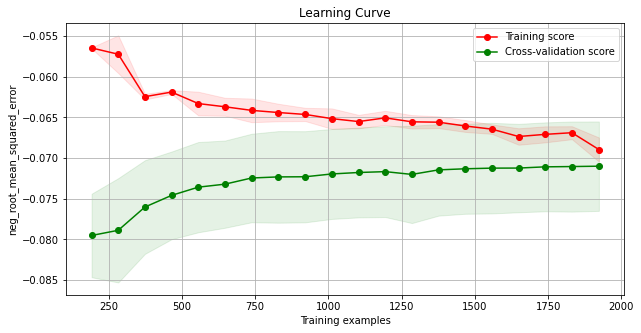

In [87]:
plot_learning_curve(ridge_reg, X_train, y_train)

In [88]:
#create a Stocahstic Gradiant Descent Regressor object
sgd_reg = SGDRegressor(max_iter=1000, tol=.01, penalty="l2", eta0=.001)

#fit the model to the training data
sgd_reg.fit(X_train, y_train)

#calcualte the predicted values
predictions = sgd_reg.predict(X_train)

#compare the predicted to the actuals to evaluate the model
rmse = mean_squared_error(y_train,predictions,squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.09023


In [89]:
#run cross validation
scores = cross_val_score(sgd_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:.5f}".format( -scores.mean() ) )

RMSE: 0.09434


In [90]:
sgd_reg.fit(X_train, y_train)

#calcualte the predicted values
predictions = sgd_reg.predict(X_test)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_test, predictions,squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.09328


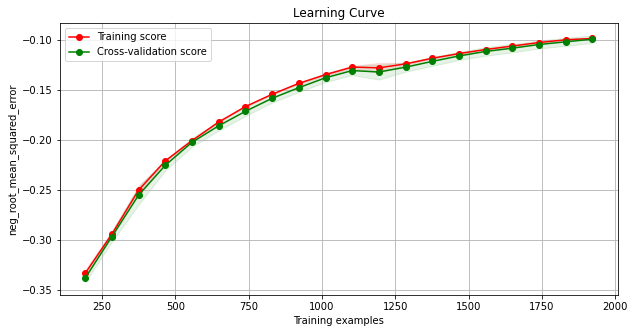

In [91]:
plot_learning_curve(sgd_reg, X_train, y_train)

In [92]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {'max_iter': [1000, 10000], 'eta0': [ .001, .01, .1],
     'tol': [.001, .01, .1],'penalty':['None', 'l2']},
  ]

# train across 10 folds, that's a total of (2*3*3*2)*10=360 rounds of training 
grid_search = GridSearchCV(SGDRegressor(), param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SGDRegressor(),
             param_grid=[{'eta0': [0.001, 0.01, 0.1], 'max_iter': [1000, 10000],
                          'penalty': ['None', 'l2'],
                          'tol': [0.001, 0.01, 0.1]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [93]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE: {:.5f} - {}".format( -mean_score, params) )

RMSE: 0.08464 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'None', 'tol': 0.001}
RMSE: 0.09441 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'None', 'tol': 0.01}
RMSE: 0.10876 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'None', 'tol': 0.1}
RMSE: 0.08465 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}
RMSE: 0.09443 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.01}
RMSE: 0.10869 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.1}
RMSE: 0.08468 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'None', 'tol': 0.001}
RMSE: 0.09435 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'None', 'tol': 0.01}
RMSE: 0.10874 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'None', 'tol': 0.1}
RMSE: 0.08465 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'l2', 'tol': 0.001}
RMSE: 0.09446 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'l2', 'tol': 0.01}
RMSE: 0.10872 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'l2', 'tol': 0.1}
RMSE: 0.07451 - {'eta0

In [94]:
grid_search.best_params_

{'eta0': 0.01, 'max_iter': 1000, 'penalty': 'None', 'tol': 0.001}

In [95]:
sgd_model = SGDRegressor(**grid_search.best_params_)
sgd_model.fit(X_train, y_train)

#calcualte the predicted values
predictions = sgd_model.predict(X_test)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_test, predictions,squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.07975


In [96]:
#create a Ridge Regression model (adds in regularization)
ridge_reg=Ridge(alpha=1, solver='auto')

#fit the model to the training data set
ridge_reg.fit(X_train, y_train)
#calculated the predicted values for the training data set
predictions = ridge_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.06918


In [97]:
X_example = full_pipeline.transform( X_instance )
#predict the one instance

In [98]:
X_instance.shape

(1, 16)

In [99]:
#predict the one instance
lin_reg.predict(X_example)

array([0.65574074])

In [100]:
sgd_model.predict( X_example )

array([0.68243706])

In [101]:
ridge_reg.predict(X_example)

array([0.65662973])

In [103]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    # try all solvers available to Ridge Regression and a few values for alpha
    {'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'saga'],
     'alpha': [1, 2, 5, 10]}
]

# train across 10 folds, that's a total of (4*6)*10=240 rounds of training 
grid_search = GridSearchCV(Ridge(), param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid=[{'alpha': [1, 2, 5, 10],
                          'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                     'sparse_cg', 'saga']}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [104]:
#print the RMSE results from the CV and the paramaters used during each run 
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE: {:.5f} - {}".format( -mean_score, params) )

RMSE: 0.07104 - {'alpha': 1, 'solver': 'auto'}
RMSE: 0.07104 - {'alpha': 1, 'solver': 'svd'}
RMSE: 0.07104 - {'alpha': 1, 'solver': 'cholesky'}
RMSE: 0.07106 - {'alpha': 1, 'solver': 'lsqr'}
RMSE: 0.07105 - {'alpha': 1, 'solver': 'sparse_cg'}
RMSE: 0.07103 - {'alpha': 1, 'solver': 'saga'}
RMSE: 0.07099 - {'alpha': 2, 'solver': 'auto'}
RMSE: 0.07099 - {'alpha': 2, 'solver': 'svd'}
RMSE: 0.07099 - {'alpha': 2, 'solver': 'cholesky'}
RMSE: 0.07105 - {'alpha': 2, 'solver': 'lsqr'}
RMSE: 0.07098 - {'alpha': 2, 'solver': 'sparse_cg'}
RMSE: 0.07103 - {'alpha': 2, 'solver': 'saga'}
RMSE: 0.07100 - {'alpha': 5, 'solver': 'auto'}
RMSE: 0.07100 - {'alpha': 5, 'solver': 'svd'}
RMSE: 0.07100 - {'alpha': 5, 'solver': 'cholesky'}
RMSE: 0.07103 - {'alpha': 5, 'solver': 'lsqr'}
RMSE: 0.07099 - {'alpha': 5, 'solver': 'sparse_cg'}
RMSE: 0.07109 - {'alpha': 5, 'solver': 'saga'}
RMSE: 0.07113 - {'alpha': 10, 'solver': 'auto'}
RMSE: 0.07113 - {'alpha': 10, 'solver': 'svd'}
RMSE: 0.07113 - {'alpha': 10, 'solv

In [105]:
#display the best soluiton
grid_search.best_params_

{'alpha': 2, 'solver': 'sparse_cg'}

In [106]:
#use the parameters found above to create the model
model = Ridge(**grid_search.best_params_)

#fit the model to the training data set
model.fit(X_train, y_train)

Ridge(alpha=2, solver='sparse_cg')

In [107]:
#use the best ridge regression model and evaluate the test data set
predictions = model.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.07624


In [108]:
#create a Stocahstic Gradiant Descent Regressor object
sgd_reg = SGDRegressor(max_iter=50000, tol=.001, penalty="l2", eta0=.001)

#fit the model to the training data
sgd_reg.fit(X_train, y_train)

#calcualte the predicted values
predictions = sgd_reg.predict(X_train)

#compare the predicted to the actuals to evaluate the model
rmse = mean_squared_error(y_train,predictions,squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.08384


In [109]:
#run cross validation
scores = cross_val_score(sgd_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:.5f}".format( -scores.mean() ) )

RMSE: 0.08468


In [110]:
sgd_reg.fit(X_train, y_train)

#calcualte the predicted values
predictions = sgd_reg.predict(X_test)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_test, predictions,squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.08762


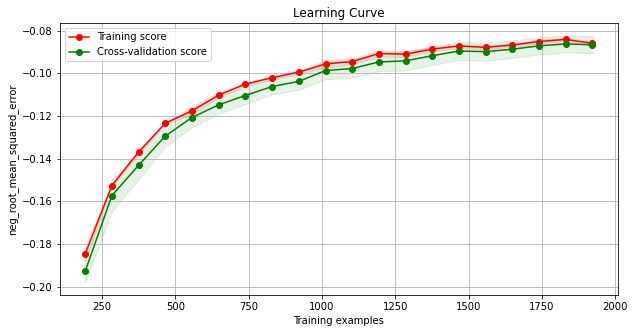

In [111]:
plot_learning_curve(sgd_reg, X_train, y_train)

In [112]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {'max_iter': [1000, 10000], 'eta0': [ .001, .01, .1],
     'tol': [.001, .01, .1],'penalty':['None', 'l2']},
  ]

# train across 10 folds, that's a total of (2*3*3*2)*10=360 rounds of training 
grid_search = GridSearchCV(SGDRegressor(), param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SGDRegressor(),
             param_grid=[{'eta0': [0.001, 0.01, 0.1], 'max_iter': [1000, 10000],
                          'penalty': ['None', 'l2'],
                          'tol': [0.001, 0.01, 0.1]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [113]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE: {:.5f} - {}".format( -mean_score, params) )

RMSE: 0.08470 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'None', 'tol': 0.001}
RMSE: 0.09444 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'None', 'tol': 0.01}
RMSE: 0.10869 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'None', 'tol': 0.1}
RMSE: 0.08470 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}
RMSE: 0.09440 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.01}
RMSE: 0.10874 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.1}
RMSE: 0.08466 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'None', 'tol': 0.001}
RMSE: 0.09436 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'None', 'tol': 0.01}
RMSE: 0.10876 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'None', 'tol': 0.1}
RMSE: 0.08467 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'l2', 'tol': 0.001}
RMSE: 0.09433 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'l2', 'tol': 0.01}
RMSE: 0.10871 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'l2', 'tol': 0.1}
RMSE: 0.07463 - {'eta0

In [114]:
grid_search.best_params_

{'eta0': 0.01, 'max_iter': 10000, 'penalty': 'l2', 'tol': 0.001}

In [115]:
sgd_model = SGDRegressor(**grid_search.best_params_)
sgd_model.fit(X_train, y_train)

#calcualte the predicted values
predictions = sgd_model.predict(X_test)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_test, predictions,squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.07912


In [116]:
#review the current shape of our training set
X_train.shape

(2404, 70)

In [117]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    # try all solvers available to Ridge Regression and a few values for alpha
    {'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'saga'],
     'alpha': [1, 2, 5, 10]}
]

# train across 10 folds, that's a total of (4*6)*10=240 rounds of training 
grid_search = GridSearchCV(Ridge(), param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid=[{'alpha': [1, 2, 5, 10],
                          'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                     'sparse_cg', 'saga']}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [118]:
#print the RMSE results from the CV and the paramaters used during each run 
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE: {:.5f} - {}".format( -mean_score, params) )

RMSE: 0.07104 - {'alpha': 1, 'solver': 'auto'}
RMSE: 0.07104 - {'alpha': 1, 'solver': 'svd'}
RMSE: 0.07104 - {'alpha': 1, 'solver': 'cholesky'}
RMSE: 0.07106 - {'alpha': 1, 'solver': 'lsqr'}
RMSE: 0.07105 - {'alpha': 1, 'solver': 'sparse_cg'}
RMSE: 0.07103 - {'alpha': 1, 'solver': 'saga'}
RMSE: 0.07099 - {'alpha': 2, 'solver': 'auto'}
RMSE: 0.07099 - {'alpha': 2, 'solver': 'svd'}
RMSE: 0.07099 - {'alpha': 2, 'solver': 'cholesky'}
RMSE: 0.07105 - {'alpha': 2, 'solver': 'lsqr'}
RMSE: 0.07098 - {'alpha': 2, 'solver': 'sparse_cg'}
RMSE: 0.07103 - {'alpha': 2, 'solver': 'saga'}
RMSE: 0.07100 - {'alpha': 5, 'solver': 'auto'}
RMSE: 0.07100 - {'alpha': 5, 'solver': 'svd'}
RMSE: 0.07100 - {'alpha': 5, 'solver': 'cholesky'}
RMSE: 0.07103 - {'alpha': 5, 'solver': 'lsqr'}
RMSE: 0.07099 - {'alpha': 5, 'solver': 'sparse_cg'}
RMSE: 0.07109 - {'alpha': 5, 'solver': 'saga'}
RMSE: 0.07113 - {'alpha': 10, 'solver': 'auto'}
RMSE: 0.07113 - {'alpha': 10, 'solver': 'svd'}
RMSE: 0.07113 - {'alpha': 10, 'solv

In [119]:
#display the best soluiton
grid_search.best_params_

{'alpha': 2, 'solver': 'sparse_cg'}

In [120]:
#use the parameters found above to create the model
model = Ridge(**grid_search.best_params_)

#fit the model to the training data set
model.fit(X_train, y_train)

Ridge(alpha=2, solver='sparse_cg')

In [121]:
#use the best ridge regression model and evaluate the test data set
predictions = model.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.07624


In [122]:
#create a Lasso Regression model
lasso_reg=Lasso(alpha=1)

#fit the model to the training data set
lasso_reg.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = lasso_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.11375


In [123]:
#run cross validation
scores = cross_val_score(lasso_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:.5f}".format( -scores.mean() ) )

RMSE: 0.11367


In [124]:
#use the best Lasso Regression model and evaluate the test data set
predictions = lasso_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.12146


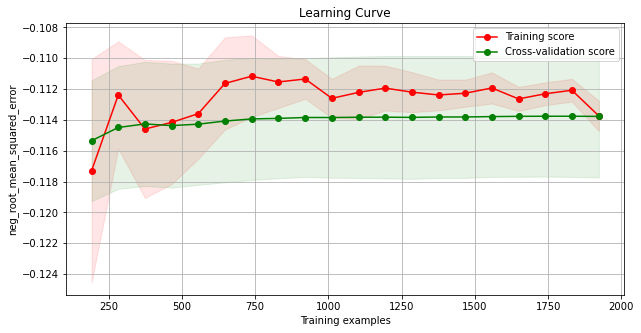

In [125]:
plot_learning_curve(lasso_reg, X_train, y_train)

In [126]:
lasso_reg.predict(X_example)

array([0.48454784])

In [127]:
#try making a linear model fit data that is more likely non-linear
DEGREE = 2

#create a polynomial feature with degree based on variable DEGREE
poly_features=PolynomialFeatures(degree=DEGREE)

#transform our X by adding the square of each feature to the training set
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

X_train_poly.shape, X_test_poly.shape

((2404, 2556), (602, 2556))

In [128]:
# use the new, complex data set to train a new model
model_poly = Ridge(tol=.1, max_iter=1000)

model_poly.fit(X_train_poly, y_train)

Ridge(max_iter=1000, tol=0.1)

In [129]:
#calcualte the predicted values
predictions = model_poly.predict(X_train_poly)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_train, predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.05273


In [130]:
#run cross validation
scores = cross_val_score(model_poly, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:.5f}".format( -scores.mean() ) )

RMSE: 0.07104


In [131]:
#calcualte the predicted values
predictions = model_poly.predict(X_test_poly)

#compare the predicted to the actuals
rmse = mean_squared_error( y_test, predictions, squared=False)
print("Predition Error (RMSE): {:.5f}".format(rmse))

Predition Error (RMSE): 0.07935


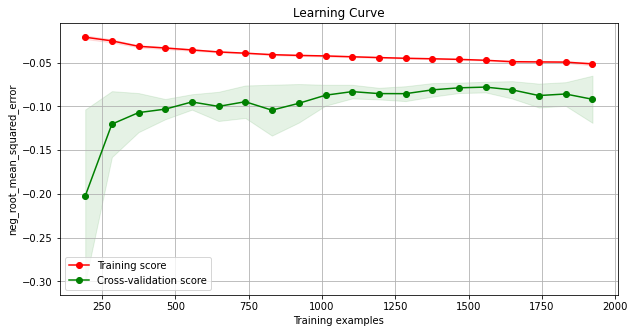

In [132]:
plot_learning_curve(model_poly,X_train_poly,y_train)

In [133]:
X_example_poly = poly_features.transform(X_example)

In [136]:
model_poly.predict(X_example_poly)

array([0.62700005])